In [13]:
#!pip install openpyxl

In [14]:
'''
Importing the data
'''
import pandas as pd
import numpy as np
data = pd.read_excel("Cleaned Data.xlsx", header=0);

In [15]:
'''
Renaming the columns
'''
data = data.rename(columns={'I am unemployed' : 'Unemployed', 'I identify as having a mental illness' : 'Mental illness',
'I have my own computer separate from a smart phone' : 'Own pc', 'How many days were you hospitalized for your mental illness' : 'Days hospitalized', 
'I am legally disabled' : 'Legally disabled', 'I have my regular access to the internet' : 'Internet access', 'I live with my parents' : 'Live with parents', 
'I have a gap in my resume' : 'Gap in resume', 'I read outside of work and school' : 'I read', 'I am on section 8 housing' : 'Section 8 housing',
'How many times were you hospitalized for your mental illness' : 'Times hospitalized', 'I have been hospitalized before for my mental illness' : 'Hospitalized',
'I receive food stamps' : 'Food stamps', 'Annual income from social welfare programs' : 'Income social welfare', 
'Annual income (including any social welfare programs) in USD' : 'Total annual income', 'Total length of any gaps in my resume in months.' : 'Total length gap (months)'})

'''
Dropping this attribute, because it's the same as the first attribute
'''
data = data.drop(columns={'I am currently employed at least part-time'})

In [16]:
'''
Dropping rows with logical fallacies
'''
obs_dropped = 0
arr = []
for i, value in enumerate(data['Hospitalized']):
    if (value == 0 and data['Times hospitalized'].iloc[i] > 0) or (value == 0 and data['Days hospitalized'].iloc[i] > 0):
        obs_dropped += 1
        arr.append(i)
print(f'There have been {obs_dropped} obsservations dropped.')
for i in arr:
    data = data.drop(i, axis=0)

There have been 28 obsservations dropped.


In [17]:
'''
Filling in some missing values and dropping the observations that still have missing values after this
'''
for i, (hos, times) in enumerate(zip(data['Hospitalized'], data['Days hospitalized'])):
    if hos == 0 and np.isnan(times):
        data['Days hospitalized'].iloc[i] = 0
data = data.dropna(axis=0);

C:\Users\teunh\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [18]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
'''
Encoding attributes, such that the algorithms we'll use can accept them
'''
# Encoding the education
education_categories = [['Some highschool', 'High School or GED', 'Some Undergraduate', 'Completed Undergraduate', 'Some\xa0Masters', 'Completed Masters', 'Some Phd', 'Completed Phd']]
education_encoder = OrdinalEncoder(categories=education_categories)
data['Education'] = education_encoder.fit_transform(data['Education'].to_numpy().reshape(-1, 1))

# Encoding the age
age_categories = [['18-29', '30-44', '45-60', '> 60']]
age_encoder = OrdinalEncoder(categories=age_categories)
data['Age'] = age_encoder.fit_transform(data['Age'].to_numpy().reshape(-1, 1))

gender_encoder = LabelEncoder()
data['Gender'] = gender_encoder.fit_transform(data['Gender'])

# Encoding the household income
income_categories = [['Prefer not to answer', '$0-$9,999', '$10,000-$24,999', '$25,000-$49,999', '$50,000-$74,999', '$75,000-$99,999', '$100,000-$124,999', '$125,000-$149,999', '$150,000-$174,999', '$175,000-$199,999', '$200,000+']]
income_encoder = OrdinalEncoder(categories=income_categories)
data['Household Income'] = income_encoder.fit_transform(data['Household Income'].to_numpy().reshape(-1, 1))

# Encoding the region
region_encoder = LabelEncoder()
data['Region'] = region_encoder.fit_transform(data['Region'])

# Encoding the divice types
device_encoder = LabelEncoder()
data['Device Type'] = device_encoder.fit_transform(data['Device Type'])

In [19]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import StratifiedKFold
'''
Hyperparameter tuning for the decision tree classifier
'''
y = data['Unemployed']
X = data.drop(columns={'Unemployed'})
ynp = y.to_numpy()
Xnp = X.to_numpy()

skf = StratifiedKFold(n_splits=10)
hp_range = np.array([x for x in range(2, 21)])
results = []

for i, mss in enumerate(hp_range):
    for j, md in enumerate(hp_range):
        acc = np.array([])
        dtc = DecisionTreeClassifier(min_samples_split=mss, max_depth=md)
        for train, test in skf.split(Xnp, ynp):
            X_train, X_test = Xnp[train], Xnp[test] 
            y_train, y_test = ynp[train], ynp[test]
            
            dtc.fit(X_train, y_train)
            acc = np.append(acc, dtc.score(X_test, y_test))
        accuracy = acc.mean()
        results.append([accuracy, mss, md])
        
results = np.array(results)

max_accuracy, max_mss, max_md = -1, -1, -1
for accuracy, mss, md in results:
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        max_mss = int(mss)
        max_md = int(md)

print(f'The optimal hyperparamters are: a minimum samples split of {max_mss} and a maximum depth of {max_md}.')

The optimal hyperparamters are: a minimum samples split of 14 and a maximum depth of 3.


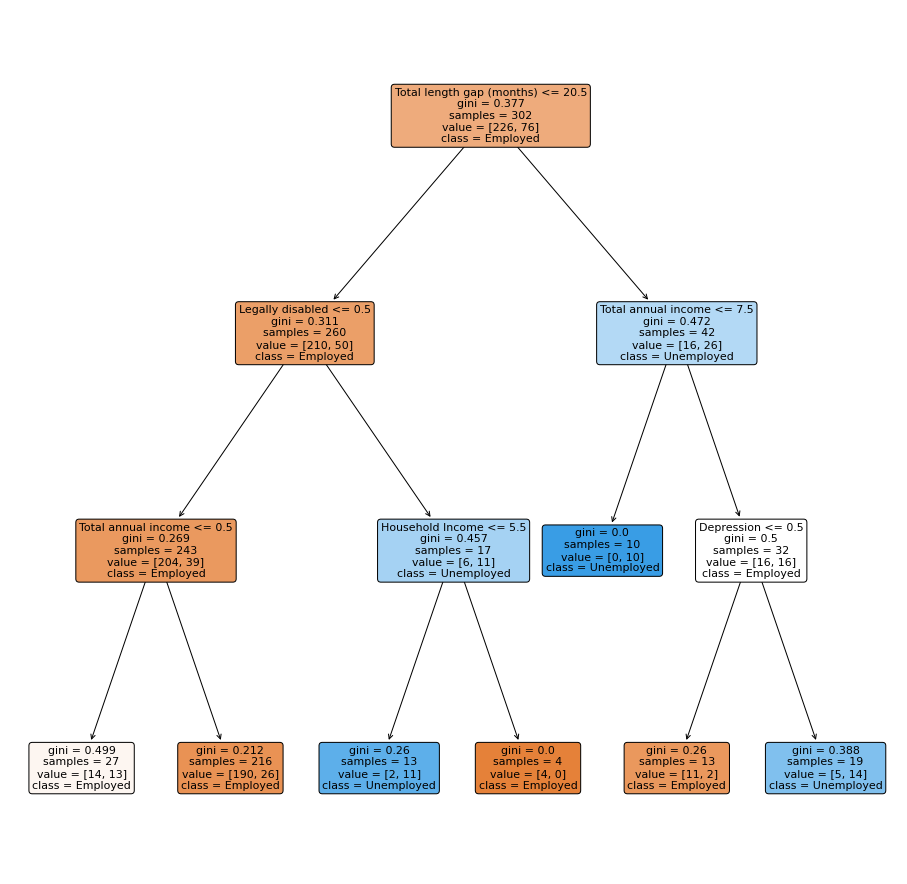

Figure 1: the decision tree with a minimum samples plit of 14 and a maximum depth of 3. This tree is fitted on the entire dataset.


In [20]:
import matplotlib.pyplot as plt
'''
Printing the optimal decision tree
'''
fig = plt.figure(figsize=(16,16))
optimal_dtc = DecisionTreeClassifier(min_samples_split=max_mss, max_depth=max_md)
optimal_dtc.fit(X, y)

plot_tree(optimal_dtc, feature_names=X.columns, class_names=['Employed', 'Unemployed'], rounded=True, filled=True, fontsize=11);
plt.show()

print(f'Figure 1: the decision tree with a minimum samples plit of {max_mss} and a maximum depth of {max_md}. This tree is fitted on the entire dataset.')

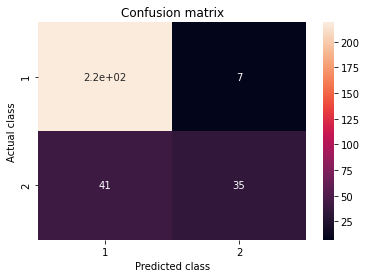

Figure 2: a confusion matrix belonging to the decision tree of Figure 2.

The accuracy of this decision tree is 0.8411.
The recall of this decision tree is 0.969.
The precision of this decision tree is 0.8423.
The f-measure of this decision tree is 0.9012.


In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
'''
Printing a confusion matrix belonging to the optimal decision tree and data
''' 
def plot_confusion_matrix(cm,y):
    df_cm = pd.DataFrame(cm, index = [i+1 for i in np.unique(y)],
                  columns = [i+1 for i in np.unique(y)])
    plt.figure()
    sns.heatmap(df_cm, annot=True)
    plt.title('Confusion matrix')
    plt.xlabel('Predicted class')
    plt.ylabel('Actual class')
    plt.show() 

pred_dtc = optimal_dtc.predict(X)
cm_dtc = confusion_matrix(y, pred_dtc)
plot_confusion_matrix(cm_dtc, ynp)
print('Figure 2: a confusion matrix belonging to the decision tree of Figure 2.\n')

accuracy_dtc = (cm_dtc[0,0] + cm_dtc[1,1]) / cm_dtc.flatten().sum()
print(f'The accuracy of this decision tree is {round(accuracy_dtc, 4)}.')
recall_dtc = cm_dtc[0,0] / (cm_dtc[0,0] + cm_dtc[0,1])
print(f'The recall of this decision tree is {round(recall_dtc, 4)}.')
precision_dtc = cm_dtc[0,0] / (cm_dtc[0,0] + cm_dtc[1,0])
print(f'The precision of this decision tree is {round(precision_dtc, 4)}.')
f_measure_dtc = (2 * cm_dtc[0,0]) / (2 * cm_dtc[0,0] + cm_dtc[1,0] + cm_dtc[0,1])
print(f'The f-measure of this decision tree is {round(f_measure_dtc, 4)}.')

The optimal k-nearest neighbour classification for the dataset has k = 4 and a cosine distance measure


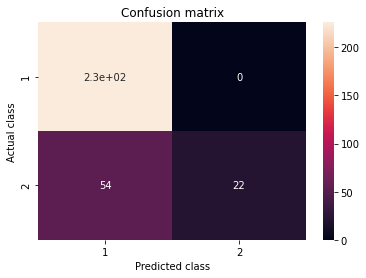

Figure 3: a confusion matrix of the prediction from the 4-nearest neigbour classifier.
The accuracy of 4-nearest neighbour classification is 0.8212.
The recall of this 4-nearest neighbour classification is 1.0.
The precision of this 4-nearest neighbour classification is 0.8071.
The f-measure of this 4-nearest neighbour classification is 0.8933.


In [22]:
from sklearn.neighbors import KNeighborsClassifier
'''
Hyperparameter tuning for the KNN-classifier
'''
def score(k, metric):
    kneighbour = KNeighborsClassifier(n_neighbors=k, metric=metric)
    scores = np.array([])
    for train, test in skf.split(Xnp, ynp):
        X_train, X_test = Xnp[train], Xnp[test] 
        y_train, y_test = ynp[train], ynp[test]
        kneighbour.fit(X_train, y_train)
        scores = np.append(scores, kneighbour.score(X_test, y_test))
    return scores.mean()

max_k = int(len(X_test)/4)
k = -1
max_s = -1
distance = ''
for metric in np.array(['euclidean','cityblock', 'cosine']):
    for i in range(max_k):
        s = score(i+1, metric)
        if s > max_s:
            distance = metric
            k = i + 1
            max_s = s

print(f'The optimal k-nearest neighbour classification for the dataset has k = {k} and a {distance} distance measure')
'''
Constructing the optimal KNN-classifier
'''
optimal_kneighbour = KNeighborsClassifier(n_neighbors=k, metric=distance)
optimal_kneighbour.fit(X, y)

'''
Printing the confusion matrix for the optimal KNN-classifier
'''
pred_knc = optimal_kneighbour.predict(X)
cm_knc = confusion_matrix(y, pred_knc)
plot_confusion_matrix(cm_knc, y)
print(f'Figure 3: a confusion matrix of the prediction from the {k}-nearest neigbour classifier.', end='\n') 

accuracy_knc = (cm_knc[0,0] + cm_knc[1,1]) / cm_knc.flatten().sum()
print(f'The accuracy of {k}-nearest neighbour classification is {round(accuracy_knc, 4)}.')
recall_knc = cm_knc[0,0] / (cm_knc[0,0] + cm_knc[0,1])
print(f'The recall of this {k}-nearest neighbour classification is {round(recall_knc, 4)}.')
precision_knc = cm_knc[0,0] / (cm_knc[0,0] + cm_knc[1,0])
print(f'The precision of this {k}-nearest neighbour classification is {round(precision_knc, 4)}.')
f_measure_knc = (2 * cm_knc[0,0]) / (2 * cm_knc[0,0] + cm_knc[1,0] + cm_knc[0,1])
print(f'The f-measure of this {k}-nearest neighbour classification is {round(f_measure_knc, 4)}.')

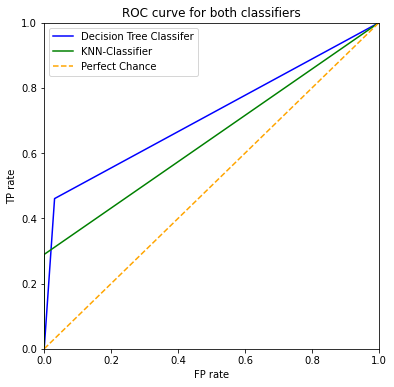

Figure 4: ROC curve for two classifiers.
The AUC-score of the decision tree classifier is 0.7148.
The AUC-score of the KNN-classifier is 0.6447.


In [23]:
from sklearn.metrics import roc_curve, roc_auc_score
'''
Making a ROC curve belonging to both the classifiers
'''
fpr_dtc, tpr_dtc, threshold_dtc = roc_curve(y_true=y, y_score=pred_dtc)
fpr_knc, tpr_knc, threshold_knc = roc_curve(y_true=y, y_score=pred_knc)

fig = plt.figure(figsize=(6, 6))
plt.plot(fpr_dtc, tpr_dtc, label='Decision Tree Classifer',color='blue')
plt.plot(fpr_knc, tpr_knc, label='KNN-Classifier', color='green')
plt.plot([0, 1], [0, 1], color='orange', linestyle='dashed', label='Perfect Chance')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve for both classifiers')
plt.legend()
plt.show()

print('Figure 4: ROC curve for two classifiers.', end='\n')
'''
Calculating the AUC score of the ROC curve
'''
auc_score_dtc = roc_auc_score(y, pred_dtc)
auc_score_knc = roc_auc_score(y, pred_knc)
print(f'The AUC-score of the decision tree classifier is {round(auc_score_dtc, 4)}.')
print(f'The AUC-score of the KNN-classifier is {round(auc_score_knc, 4)}.')